In [2]:
using Pkg

venv_dir = (@__DIR__) * "../../muc_venv/"
Pkg.activate(venv_dir)

using Revise
import PhysicalConstants.CODATA2018: G
using NaturallyUnitful
using DifferentialEquations
using Roots
using QuadGK
using PythonPlot
using LaTeXStrings
import SpecialFunctions: besselk
import DelimitedFiles: writedlm, readdlm

figdir = "./"

golden_ratio = (1+sqrt(5))/2

const lifetime_conv = ustrip(unnatural(u"s", 1*u"GeV^-1"))

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")
;

  Activating project at `~/Library/CloudStorage/Dropbox/research/muon-collider/flavored-dm/flavored-dm/Sam/relic_abundance/muc_venv`


In [3]:
includet(venv_dir*"boltz_utils.jl")
using .utils

#includet(venv_dir*"hubble.jl")
#using .Hubble
includet(venv_dir*"gstar.jl")
using .gstar

includet((@__DIR__)*"/cross_sections.jl")
using .QLFlavorDM

#### Define Cross-Sections and Differential Equations

In [16]:
function pi2σ_φuφu_to_f(α, model::QLFDM)
    3*pi2σ_φuφu_to_uu(α, model) +  
    3*pi2σ_φuφu_to_dd(α, model) +  
    3*pi2σ_φuφu_to_ll(α, model) +  
    3*pi2σ_φuφu_to_vv(α, model) +  
    pi2σ_φuφu_to_WW(α, model) +  
    pi2σ_φuφu_to_γγ(α, model) + 
    pi2σ_φuφu_to_ZZ(α, model) +  # this one doesn't fall at all
    pi2σ_φuφu_to_Zγ(α, model) + 
    pi2σ_φuφu_to_Zh(α, model) + 
    pi2σ_φuφu_to_gg(α, model) +  
    pi2σ_φuφu_to_gγ(α, model) +  
    pi2σ_φuφu_to_gZ(α, model) 
end

function pi2σ_φdφd_to_f(α, model::QLFDM)
    3*pi2σ_φdφd_to_uu(α, model) +  
    3*pi2σ_φdφd_to_dd(α, model) +  
    3*pi2σ_φdφd_to_ll(α, model) +  
    3*pi2σ_φdφd_to_vv(α, model) +  
    pi2σ_φdφd_to_WW(α, model) +  
    pi2σ_φdφd_to_γγ(α, model) +  
    pi2σ_φdφd_to_ZZ(α, model) +  # this one doesn't fall at all
    pi2σ_φdφd_to_Zγ(α, model) +  
    pi2σ_φdφd_to_Zh(α, model) +  
    pi2σ_φdφd_to_gg(α, model) +  
    pi2σ_φdφd_to_gγ(α, model) +  
    pi2σ_φdφd_to_gZ(α, model)
end

function pi2σ_φuφd_to_f(α, model::QLFDM)
    3*pi2σ_φuφd_to_quqd(α, model) + 
    3*pi2σ_φuφd_to_lvl(α, model) +  
    pi2σ_φuφd_to_Wpγ(α, model) +  
    pi2σ_φuφd_to_WpZ(α, model) +  # this one doesn't fall at all
    pi2σ_φuφd_to_Wpg(α, model) +  
    pi2σ_φuφd_to_Wph(α, model)
end

function lifetime_φu(λ, mφ, mχ)
    mm = QLFDM(λ, mφ, mχ)
    decay = 2*Γ_φu_to_χq(mm) + Γ_φu_to_χt(mm) + Γ_φu_to_φdeν(mm) + Γ_φu_to_φdμν(mm)
    return lifetime_conv / decay
end

function lifetime_φd(λ, mφ, mχ)
    mm = QLFDM(λ, mφ, mχ)
    decay = 3*Γ_φd_to_χq(mm)
    return lifetime_conv / decay
end
;

In [34]:
function φu_totwidth(model::QLFDM)
    2*Γ_φu_to_χq(model) + Γ_φu_to_χt(model) + Γ_φu_to_φdeν(model) + Γ_φu_to_φdμν(model)
end

function φd_totwidth(model::QLFDM)
    3*Γ_φd_to_χq(model)
end
;

In [17]:
test_array = [ 1/x^2*pi2σ_φuφd_to_f(25., QLFDM(1e-12, x, 1e-4)) for x in [1000., 2000., 3000., 4000.] ]
[ test_array[1]/test_array[2], test_array[1]/test_array[3], test_array[1]/test_array[4] ]

3-element Vector{Float64}:
  4.001055383522988
  9.002814287890807
 16.00527674505271

In [18]:
function diffeq(du, u, p, x)
    zeq = z_eq(x, p.gφ)
    zeqx = z_eq(x*p.mχ/p.mφ, p.gχ)

    # note: these track the abundance of φu and φd of a *specific* color; 
    #   the total abundance is 3 times this.
    zu, zd, Yx = u

    c12_u_χ =  2*C12(Γ_φu_to_χq, x, p.mφ; args=(p,)) + C12(Γ_φu_to_χt, x, p.mφ; args=(p,))
    c12_d_χ = 3*C12(Γ_φd_to_χq, x, p.mφ; args=(p,))
    c12_χ = c12_u_χ + c12_d_χ
    c12_φd = C12(Γ_φu_to_φdeν, x, p.mφ; args=(p,))

    c22_φu = C22(pi2σ_φuφu_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_φd = C22(pi2σ_φdφd_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_cross = C22(pi2σ_φuφd_to_f, x, p.mφ, p.gφ; args=(p,))

    du[1] = c22_φu * (exp(-zu) - exp(zu - 2*zeq)) + 
            c22_cross * (exp(-zd) - exp(zu - 2*zeq)) + 
            c12_u_χ * (1 - Yx*exp(zu - zeq + zeqx)) +
            c12_φd * (1 - exp(zu - zd))

    du[2] = c22_φd * (exp(-zd) - exp(zd - 2*zeq)) + 
            c22_cross * (exp(-zu) - exp(zd - 2*zeq)) +
            c12_d_χ * (1 - Yx*exp(zd - zeq + zeqx)) +
            c12_φd * ( 1 - exp(zd - zu))

    # factor of 3 because we have 3 colors of the φ, each decaying to χ
    du[3] = 3*c12_u_χ * (exp(-zu) - Yx*exp(-zeq+zeqx))+ 3*c12_d_χ * (exp(-zd) - Yx*exp(-zeq+zeqx))

end

function diffeq_φ(du, u, p, x)

    zeq = z_eq(x, p.gφ)

    # note: these track the abundance of φu and φd of a *specific* color; 
    #   the total abundance is 3 times this.
    zu, zd = u 

    c12_φd = C12(Γ_φu_to_φdeν, x, p.mφ; args=(p,))

    c22_φu = C22(pi2σ_φuφu_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_φd = C22(pi2σ_φdφd_to_f, x, p.mφ, p.gφ; args=(p,))
    c22_cross = C22(pi2σ_φuφd_to_f, x, p.mφ, p.gφ; args=(p,))

    du[1] = 0
    du[2] = 0

    du[1] = c22_φu * (exp(-zu) - exp(zu - 2*zeq)) + 
            c22_cross * (exp(-zd) - exp(zu - 2*zeq)) + 
            c12_φd * (1 - exp(zu - zd))

    du[2] = c22_φd * (exp(-zd) - exp(zd - 2*zeq)) + 
            c22_cross * (exp(-zu) - exp(zd - 2*zeq)) +
            c12_φd * (1 - exp(zd - zu))

end


diffeq_φ (generic function with 1 method)

In [19]:
Γ_φu_to_χt(QLFDM(1., 200., 1., 28., 2))

0.0

In [22]:
function solve_boltz(λ, mφ, mχ; xspan=(1e-4, 1e8))
    mm = QLFDM(λ, mφ, mχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0]
    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return sol
end

function find_yφfo(mφ; xspan=(1e-4, 1e8))
    mm = QLFDM(0.0, mφ, 0.0)

    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ)]

    prob = ODEProblem(diffeq_φ, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return exp.(-sol(xspan[2]))
end

function yχf_I(mφ)
    quadgk(x -> x^3*besselk(1,x)/sqrt(gstar_interp(mφ/x)), 0, Inf)[1]
end

"""
    find_yχf(λ, mφ, mχ; gφ=1)

Calculates the final χ yield, assuming φ remains in equilibrium
"""
function find_yχfi(λ, mφ, mχ; gφ=1)
    mm = QLFDM(λ, mφ, gφ, mχ, 2)
    I = yχf_I(mφ)
    return 3 * I * gφ*(2*Γ_φu_to_χq(mm) + Γ_φu_to_χt(mm) + 3*Γ_φd_to_χq(mm)) / (2*π^2*mφ^2*utils.h_consts)
end

"""
    find_yχf(I, λ, mφ, mχ; gφ=1)

When called with the result of the integral as the first argument, skips
re-calculating the integral (useful because the integral only depends on mφ)
"""
function find_yχfi(I, λ, mφ, mχ; gφ=1)
    mm = QLFDM(λ, mφ, gφ, mχ, 2)

    return 3 * I * gφ*(2*Γ_φu_to_χq(mm) + Γ_φu_to_χt(mm) + 3*Γ_φd_to_χq(mm)) / (2*π^2*mφ^2*utils.h_consts)
end


function find_yχf_full(λ, mφ, mχ; xspan=(1e-4, 1e8))
    mm = QLFDM(λ, mφ, mχ)

    # y0 = [Y_eq(xspan[1], mm.gφ), 0.0]
    z0 = [z_eq(xspan[1], mm.gφ), z_eq(xspan[1], mm.gφ), 0.0]

    prob = ODEProblem(diffeq, z0, xspan, mm)
    sol = solve(prob, Rodas4P(); reltol=1e-8, verbose=false)

    return sol(xspan[2])[3]
end

# factor of 3 due to the different colors of φ
function find_mχ_max()
    find_zero(x -> utils.Mstar_s(x/25) - 3*x*sum(find_yφfo(x)), (1e3, 1e6))
end

# factor of 3 due to the different colors of φ
# mχ_max default value set to output of find_mχ_max()
function mχ_upper_bound(mφ; mχ_max=5372.3645609359055)
    if mφ > mχ_max
        return Mstar_s(mφ/25)/(3*sum(find_yφfo(mφ)))
    else
        return mφ
    end
end
;

In [21]:
find_mχ_max()

5372.3645609359055

In [23]:
mφ_for_bounds = 10 .^ range(log10(100), log10(200000), 200)
mχ_uppers = mχ_upper_bound.(mφ_for_bounds)

writedlm("mphi_for_mchi_bounds.csv", mφ_for_bounds)
writedlm("mchi_uppers.csv", mχ_uppers)
;

In [24]:
mφ_for_bounds = readdlm("mphi_for_mchi_bounds.csv")[:,1]
mχ_uppers = readdlm("mchi_uppers.csv")[:,1]

200-element Vector{Float64}:
 100.0
 103.89343140333297
 107.93845088759063
 112.14096043071922
 116.50709180012815
 121.0432154993843
 125.75595006324146
 130.65217171456342
 135.73902439723489
 141.0239301996946
   ⋮
 222.01714731292444
 214.03673542110457
 206.34373563159795
 198.9277331045594
 191.77882774371807
 184.88735362081053
 178.24399874081632
 171.83979795355216
 165.66615824460177

In [27]:
λ = 1e-11
mφ = 1e3 # GeV
mχ = 1e-1 # GeV

sol = solve_boltz(λ, mφ, mχ);
yφfo = find_yφfo(mφ);
yχfi = find_yχfi(λ, mφ, mχ);

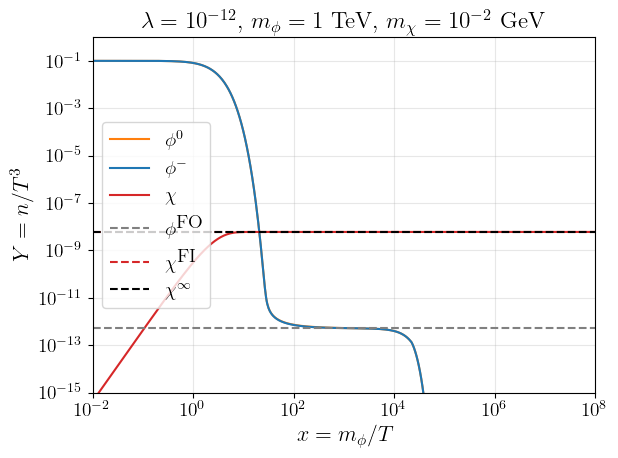

In [28]:
xs = 10 .^ range(-4, 8, 1000)
s = sol(xs)
Y_phim = exp.(-s[1,:])
Y_phi0 = exp.(-s[2,:])
Y_chi = s[3,:]

fig = figure()

plot(xs, Y_phi0, label=L"$\phi^0$", c="tab:orange")
plot(xs, Y_phim, label=L"$\phi^-$", c="tab:blue")
plot(xs, Y_chi, label=L"$\chi$", c="tab:red")

axhline(0.5*sum(yφfo), c="grey", ls="dashed", label=L"\phi^{\textrm{FO}}")
axhline(yχfi, c="tab:red", ls="dashed", label=L"\chi^{\textrm{FI}}")
axhline(yχfi+sum(yφfo), c="black", ls="dashed", label=L"\chi^{\infty}")

xlim(1e-2, 1e8)
ylim(1e-15, 1)

xscale("log")
yscale("log")

grid(alpha=0.3)

legend()

xlabel(L"x = m_\phi/T")
ylabel(L"Y = n/T^3")
title(L"$\lambda = 10^{-12}$, $m_\phi = 1$ TeV, $m_\chi = 10^{-2}$ GeV")

plotclose()
# fig.savefig("boltz_LL.pdf")
fig

Compute the coupling that gives the correct relic abundance:

In [29]:
function find_λ(mφ, mχ)
    # factor of 3 for the different colors of φ
    if mχ > mφ
        return NaN
    else
        yφfo = 3*sum(find_yφfo(mφ))
        yχfi = find_yχfi(1.0, mφ, mχ)

        return sqrt( (Mstar_s(mφ/25)/mχ - yφfo) / yχfi )
    end
end

function find_λs(Mφ, Mχ)
    result = zeros(Float64, (length(Mφ), length(Mχ)))
    Threads.@threads for i in eachindex(Mφ)
        # factor of 3 for the different colors of φ
        yφfo = 3*sum(find_yφfo(Mφ[i]))
        yχI = yχf_I(Mφ[i])

        for j in eachindex(Mχ)
            if (Mχ[j] < Mstar_s(Mφ[i]/25)/yφfo) & (Mχ[j] < Mφ[i])
                yχfi = find_yχfi(yχI, 1.0, Mφ[i], Mχ[j])
                result[i,j] = sqrt( (Mstar_s(Mφ[i]/25)/Mχ[j] - yφfo) / yχfi )
            else
                result[i,j] = NaN
            end
        end
    end
    return result
end
;

Setup Grids for Exporting to MadGraph

In [31]:
find_λ(400.,370.)

9.217480358933936e-12

In [40]:
mχ_uppers

150-element Vector{Float64}:
  100.0
  105.23363296222021
  110.74117506427271
  116.53696170518647
  122.63607854615907
  129.0544007765251
  135.808634434761
  142.9163598920798
  150.39607761179695
  158.2672563035741
    ⋮
 7614.6152459956475
 7728.148582730394
 7847.287312360699
 7972.124290348006
 8102.7572597731405
 8239.27899695607
 8381.779616141603
 8530.359358117852
 8685.11264256203

In [81]:
#mphis = vcat(100.0:25.0:350.0, 400.0:50.0:800.0, 900.0:100.0:1600.0, 1800.0:200.0:3000.0, 3250.0:250.0:10000.0)
mphis = vcat(400.0:50.0:800.0, 900.0:100.0:1600.0, 1800.0:200.0:3800.0, 4000.0:200.0:10000.0)
mchis = 10 .^ range(-5.0, 4.0, 100)
lambdas = find_λs(mphis, mchis)

writedlm("QL_lambdas_grid.csv", lambdas)
writedlm("mphis_grid.csv", mphis)
writedlm("mchis_grid.csv", mchis)

In [48]:
lambdas = readdlm("QL_lambdas_grid.csv")
mphis = readdlm("mphis_grid.csv")[:,1]
mchis = readdlm("mchis_grid.csv")[:,1]
;

In [39]:
models[50,1]

QLFDM{Float64}(3.592298902342088e-8, 9250.0, 1.0, 1.0e-5, 2.0, 0.11055267460628139, 1.2007979298421087e-10)

In [42]:
Γ_φu_to_χq(QLFDM(1.e-8, 400., 1000.))

2.193354059485183e-14

In [82]:
models = QLFDM.(lambdas, mphis, mchis')
phiu_lifetimes = lifetime_φu.(lambdas, mphis, mchis');
phid_lifetimes = lifetime_φd.(lambdas, mphis, mchis');
phiu_totwidth = φu_totwidth.(models)
phid_totwidth = φu_totwidth.(models)

phiu_BR_qchi = 2*Γ_φu_to_χq.(models) ./ phiu_totwidth
phiu_BR_phidenu = 2*Γ_φu_to_φdeν.(models) ./ phiu_totwidth

writedlm("phiu_totwidth.csv", phiu_totwidth)
writedlm("phiu_br_qchi.csv", phiu_BR_qchi)
writedlm("phiu_br_phidenu.csv", phiu_BR_phidenu)

writedlm("phiu_lifetimes_sec.csv", phiu_lifetimes)
writedlm("phid_lifetimes_sec.csv", phid_lifetimes)

In [84]:
phiu_lifetimes = readdlm("phiu_lifetimes_sec.csv")
phid_lifetimes = readdlm("phid_lifetimes_sec.csv")

phiu_totwidth = readdlm("phiu_totwidth.csv")
phiu_BR_qchi = readdlm("phiu_br_qchi.csv")
phiu_BR_phidenu = readdlm("phiu_br_phidenu.csv")
;

## Plots

In [18]:
find_λ(398.,350.)

6.028012878680771e-12

In [17]:
10^2.6

398.1071705534973

In [76]:
# finer grid of mphi, mchi for the plots
mphis_for_plots = 10 .^ range(2.6, 5, 200)
mchis_for_plots = 10 .^ range(-5, 5, 200)
lambdas_for_plots = find_λs(mphis_for_plots, mchis_for_plots)

200×200 Matrix{Float64}:
 7.61148e-9  7.18362e-9  6.77982e-9  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 7.71116e-9  7.2777e-9   6.8686e-9      NaN  NaN  NaN  NaN  NaN  NaN  NaN
 7.81279e-9  7.37362e-9  6.95913e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 7.9164e-9   7.4714e-9   7.05142e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.01906e-9  7.56829e-9  7.14286e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.1221e-9   7.66554e-9  7.23464e-9  …  NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.22696e-9  7.7645e-9   7.32804e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.33366e-9  7.86521e-9  7.42309e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.44393e-9  7.96928e-9  7.52131e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 8.55766e-9  8.07662e-9  7.62262e-9     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 ⋮                                   ⋱              ⋮                 
 1.0569e-7   9.97493e-8  9.41422e-8     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.07168e-7  1.01144e-7  9.54584e-8     NaN  NaN  NaN  NaN  NaN  NaN  NaN
 1.08666e-7  1.0

In [77]:
writedlm("QL_lambdas_for_plot_grid.csv", lambdas_for_plots)
writedlm("mphis_for_plot_grid.csv", mphis_for_plots)
writedlm("mchis_for_plot_grid.csv", mchis_for_plots)

In [25]:
lambdas_for_plots = readdlm("QL_lambdas_for_plot_grid.csv")
mphis_for_plots = readdlm("mphis_for_plot_grid.csv")[:,1]
mchis_for_plots = readdlm("mchis_for_plot_grid.csv")[:,1]
;

In [ ]:
models_for_plots = QLFDM.(lambdas_for_plots, mphis_for_plots, mchis_for_plots')
phiu_lifetimes_for_plots = lifetime_φu.(lambdas_for_plots, mphis_for_plots, mchis_for_plots');
phid_lifetimes_for_plots = lifetime_φd.(lambdas_for_plots, mphis_for_plots, mchis_for_plots');
phiu_totwidth_for_plots = φu_totwidth.(models_for_plots)
phid_totwidth_for_plots = φd_totwidth.(models_for_plots)

phiu_BR_qchi_for_plots = 2*Γ_φu_to_χq.(models_for_plots) ./ phiu_totwidth_for_plots
phiu_BR_phidenu_for_plots = 2*Γ_φu_to_φdeν.(models_for_plots) ./ phiu_totwidth_for_plots

writedlm("phiu_totwidth_for_plot.csv", phiu_totwidth_for_plots)
writedlm("phid_totwidth_for_plot.csv", phid_totwidth_for_plots)
writedlm("phiu_br_qchi_for_plot.csv", phiu_BR_qchi_for_plots)
writedlm("phiu_br_phidenu_for_plot.csv", phiu_BR_phidenu_for_plots)

writedlm("phiu_lifetimes_sec_for_plot.csv", phiu_lifetimes_for_plots)
writedlm("phid_lifetimes_sec_for_plot.csv", phid_lifetimes_for_plots)

In [52]:
phiu_totwidth

53×100 Matrix{Float64}:
 1.23485e-15  1.23485e-15  1.23485e-15  …  1.55845e-10  3.60623e-10
 1.58889e-15  1.58889e-15  1.58889e-15     1.22073e-10  2.82601e-10
 1.9819e-15   1.9819e-15   1.9819e-15      9.80368e-11  2.27069e-10
 2.42245e-15  2.42245e-15  2.42245e-15     8.06566e-11  1.86916e-10
 2.89996e-15  2.89996e-15  2.89996e-15     6.73786e-11  1.5624e-10
 3.41819e-15  3.41819e-15  3.41819e-15  …  5.71022e-11  1.32497e-10
 3.97856e-15  3.97856e-15  3.97856e-15     4.9005e-11   1.1379e-10
 4.58637e-15  4.58637e-15  4.58637e-15     4.25575e-11  9.88942e-11
 5.23685e-15  5.23685e-15  5.23685e-15     3.72936e-11  8.6733e-11
 6.66198e-15  6.66198e-15  6.66198e-15     2.92782e-11  6.82144e-11
 ⋮                                      ⋱               
 5.32745e-13  5.32745e-13  5.32745e-13     2.83117e-16  1.12414e-13
 5.66567e-13  5.66567e-13  5.66567e-13  …  4.24133e-16  8.3194e-14
 6.0143e-13   6.0143e-13   6.0143e-13      4.63454e-15  5.91686e-14
 6.37333e-13  6.37333e-13  6.37333e-13 

In [44]:
testmodel = QLFDM(λ, mφ, mχ)

QLFDM{Float64}(1.0e-11, 1000.0, 1.0, 0.1, 2.0, 0.10736487150507341, 1.4034161342201415e-12)

In [ ]:
mχ_upper_for_plots = mχ_upper_bound.(mphis_for_plots)
;

In [200]:
mchis_for_plots

200-element Vector{Float64}:
      1.0e-5
      1.1226677735108135e-5
      1.2603829296797274e-5
      1.414991297434576e-5
      1.588565129428053e-5
      1.7834308769319092e-5
      2.0022003718155845e-5
      2.2478058335487252e-5
      2.523539170434766e-5
      2.833096101839324e-5
      ⋮
  39626.88638701478
  44487.82831127585
  49945.0511585514
  56071.69938205458
  62949.88990221888
  70671.81273927492
  79340.96665797492
  89073.5463861044
 100000.0

In [201]:
lam2 = zeros(Float64, size(lambdas_for_plots))
for i in eachindex(mphis_for_plots)
for j in eachindex(mchis_for_plots)
if 2*mchis_for_plots[j] > mphis_for_plots[i]
lam2[i,j] = NaN
else
lam2[i,j] = lambdas_for_plots[i,j]
end
end
end

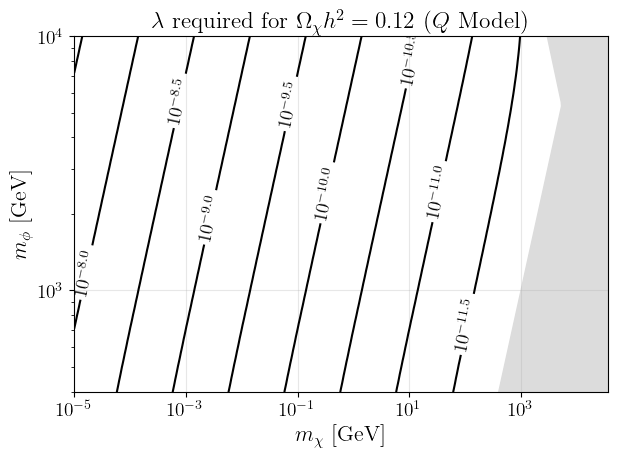

In [208]:
fig3 = figure()

xlim(1e-5, 3.6e4)
ylim(4e2, 1e4)

xscale("log")
yscale("log")
grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$ ($Q$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5])
#C = contour(mchis_for_plots, mphis_for_plots, lambdas_for_plots, levels=levels, norm="log", colors="k")
mphi_indices = mphis_for_plots .<= 1e4
mchi_indices = mchis_for_plots .<1e99
C = contour(mchis_for_plots[mchi_indices], mphis_for_plots[mphi_indices], lam2[mphi_indices,mchi_indices], levels=levels, norm="log", colors="k")

formatter(l) = L"10^{ %$(log10(l)) }"

lvs = 10 .^reverse([-6, -6.5, -7, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5])
# lvs = levels

fill_betweenx(mφ_for_bounds, mχ_uppers, 5e4, color="gainsboro")#, alpha=0.2)

clabel(C, lvs[1:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true, inline_spacing=5, fontsize=14)#, manual=((3e-5, 5e3), (3e-4, 4e3),
        # (3e-3, 3e3), (3e-2, 3e3), (3e-1, 3e3), (3e0, 3e3), (3e1, 3e2)))

plotclose()
fig3.savefig(figdir * "QL_lambda_relic.pdf", bbox_inches="tight")
fig3

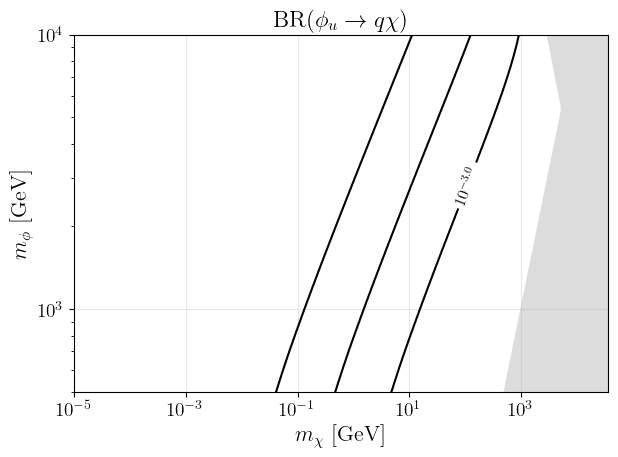

In [ ]:
fig3 = figure()

xlim(1e-5, 3.6e4)
ylim(4e2, 1e4)

xscale("log")
yscale("log")
grid(alpha=0.3)

title(L"$\textrm{BR}(\phi_u \to q\chi)$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

#levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11, -11.5])
levels = 10.0 .^reverse([0, -1, -2, -3])
#C = contour(mchis_for_plots, mphis_for_plots, lambdas_for_plots, levels=levels, norm="log", colors="k")
C = contour(mchis_for_plots, mphis_for_plots, phiu_BR_qchi_for_plots, levels=levels, norm="log", colors="k")

formatter(l) = L"10^{ %$(log10(l)) }"
# lvs = 10 .^reverse([0, -1, -2, -3])
# lvs = 10 .^reverse([-6, -6.5, -7, -8, -8.5, -9, -9.5, -10, -11, -11.5])
lvs = levels

fill_betweenx(mφ_for_bounds, mχ_uppers, 5e4, color="gainsboro")#, alpha=0.2)

clabel(C, lvs[1:end-3], colors="black", fmt=formatter, use_clabeltext=true, 
        inline=true, inline_spacing=5, fontsize=12)#, manual=((3e-5, 5e3), (3e-4, 4e3),
        # (3e-3, 3e3), (3e-2, 3e3), (3e-1, 3e3), (3e0, 3e3), (3e1, 3e2)))

plotclose()
fig3.savefig(figdir * "QL_phiu_BR_qchi_contours.pdf", bbox_inches="tight")
fig3

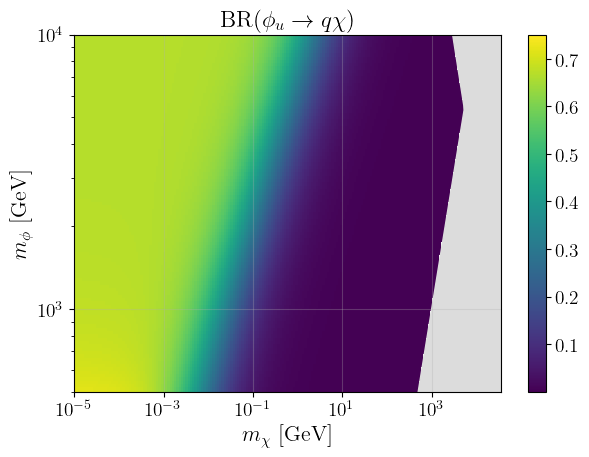

In [ ]:
f6 = figure()

xlim(1e-5, 3.6e4)
ylim(4e2, 1e4)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\textrm{BR}(\phi_u \to q\chi)$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

# levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = pcolormesh(mchis_for_plots, mphis_for_plots, phiu_BR_qchi_for_plots)
colorbar(C)

fill_betweenx(mφ_for_bounds, mχ_uppers, 5e4, color="gainsboro")#, alpha=0.2)

plotclose()
f6.savefig(figdir * "QL_phiu_BR_qchi_colorbar.pdf", bbox_inches="tight")
f6

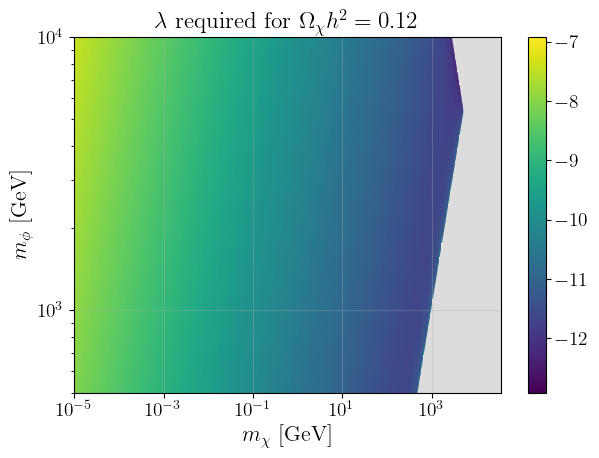

In [100]:
f6 = figure()

xlim(1e-5, 3.6e4)
ylim(5e2, 1e4)

xscale("log")
yscale("log")

grid(alpha=0.3)

title(L"$\lambda$ required for $\Omega_\chi h^2 = 0.12$")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

# levels = 10 .^reverse([-6, -6.5, -7, -7.5, -8, -8.5, -9, -9.5, -10, -10.5, -11])
C = pcolormesh(mchis_for_plots, mphis_for_plots, log10.(lambdas_for_plots))
colorbar(C)

fill_betweenx(mφ_for_bounds, mχ_uppers, 5e4, color="gainsboro")#, alpha=0.2)

plotclose()
# f6.savefig("pcolormesh_lambda_relic.pdf")
f6

In [179]:
# made with the mphis_for_plots grid
mχ_prompt_u = readdlm("mchi_phiu_prompt_for_plot.csv", ',', Float16)[:,2]
mχ_prompt_d = readdlm("mchi_phid_prompt_for_plot.csv", ',', Float16)[:,2]
;

In [174]:
# limits on the up component of the mediator, based on the LHC gluino recasts (derived in MMA notebook)
mchi_llplimit = readdlm("mchi_llp_limit.csv", ',', Float16)[:,1]
mphi_llplimit_phiu = readdlm("mphi_llp_phiu_limit.csv", ',', Float16)[:,1]
mphi_llplimit_phid= readdlm("mphi_llp_phid_limit.csv", ',', Float16)[:,1]
;

In [151]:
[mphis_for_plots .<= 1e4]

1-element Vector{BitVector}:
 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1  …  0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

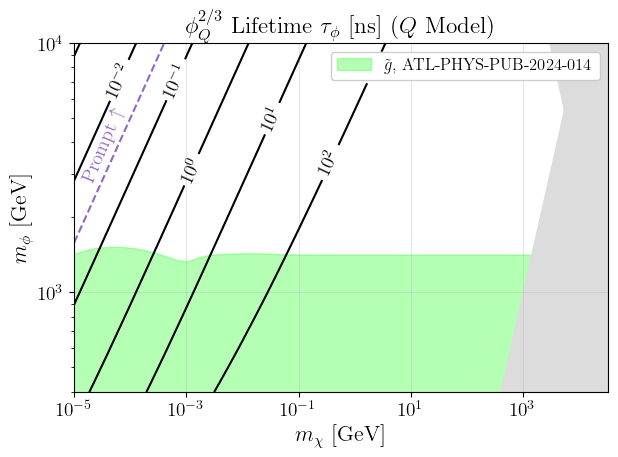

In [ ]:
fig4 = figure()

xlim(1e-5, 3.2e4)
ylim(4e2, 1e4)

xscale("log")
yscale("log")

#levels = 10.0 .^(-6:12)
levels = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2]
plot_indices = mphis_for_plots .< 1.0e4
phiu_lifetimes_trunc = phiu_lifetimes_for_plots[plot_indices,1:end]
C = contour(mchis_for_plots, mphis_for_plots[plot_indices], phiu_lifetimes_trunc .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels, colors="black", fmt=formatter, fontsize=14, use_clabeltext=true, inline=true)

fill_between(mchi_llplimit, mphi_llplimit_phiu, [0.0 for _ in mphi_llplimit_phiu], color="xkcd:neon green", alpha=0.3, label=L"$\tilde{g}$, ATL-PHYS-PUB-2024-014")
fill_betweenx(mφ_for_bounds, mχ_uppers, 5e4, color="gainsboro")#, alpha=0.2)

# plot(mχ_prompt, Mphis_life)
plot(mχ_prompt_u, mphis_for_plots, c="tab:purple", linestyle="dashed")
text(1.28e-5, 2.8e3, L"Prompt $\uparrow$",rotation=67, c="tab:purple")
text(2.e-1, 3e3, L"10^2",rotation=65, backgroundcolor="white")

grid(alpha=0.3)

title(L"$\phi_Q^{2/3}$ Lifetime $\tau_{\phi}$ [ns] ($Q$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1, loc="upper right")

plotclose()
fig4.savefig(figdir * "QL_phiu_lifetime.pdf")
fig4

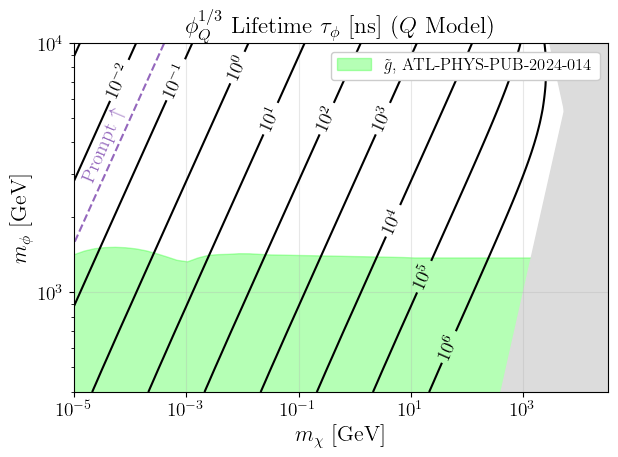

In [194]:
fig4 = figure()

xlim(1e-5, 3.2e4)
ylim(4e2, 1e4)

xscale("log")
yscale("log")

#levels = 10.0 .^(-6:12)
levels = [1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 1e2, 1e3, 1e4, 1e5, 1e6]
plot_indices = mphis_for_plots .< 1.0e4
C = contour(mchis_for_plots, mphis_for_plots[plot_indices], phid_lifetimes_for_plots[plot_indices,1:end] .* 1e9, levels=levels, norm="log", colors="black")

formatter(l) = L"10^{ %$(Int(log10(l))) }"

clabel(C, levels, colors="black", fmt=formatter, use_clabeltext=true, inline=true)

fill_between(mchi_llplimit, mphi_llplimit_phid, [0.0 for _ in mphi_llplimit_phid], color="xkcd:neon green", alpha=0.3, label=L"$\tilde{g}$, ATL-PHYS-PUB-2024-014")
fill_betweenx(mφ_for_bounds, mχ_uppers, 5e4, color="gainsboro")#, alpha=0.2)

# plot(mχ_prompt, Mphis_life)
plot(mχ_prompt_d, mphis_for_plots, c="tab:purple", linestyle="dashed")
text(1.28e-5, 2.8e3, L"Prompt $\uparrow$",rotation=67, c="tab:purple")


grid(alpha=0.3)

#title(L"$\tau_{\phi}$ [ns], $\lambda = \lambda^*$")
title(L"$\phi_Q^{1/3}$ Lifetime $\tau_{\phi}$ [ns] ($Q$ Model)")
xlabel(L"$m_\chi$ [GeV]")
ylabel(L"$m_\phi$ [GeV]")

legend(fontsize=12, framealpha=1, loc="upper right")

plotclose()
fig4.savefig(figdir * "QL_phid_lifetime.pdf")
fig4